## Sample use of the mechanical analysis tool for AFM curves

Code by Mauricio Cano Galván

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from preproc import mechanical_curve, get_rough_topo, sensitivity_analysis, visualize_curves
from os import listdir
from os.path import isfile, join
from models import cone, cone_bottom_herman, parab_bott_herman, hertz_r_free, FaSphereGO5good, FaSphereGomila_limit, FaSphereGomila
from tqdm import tqdm
from IPython.display import clear_output

To use this code in a set of curves, specify a folder with curves in .txt format.

Always keep paths in the format `r'your_path'`.

For more information on the format requirements, go to the README file.

In [2]:
path=r'C:\Users\mcano\Code2\data\raw\bea\double_regime\processed_curves-2024.12.18-14.30.03'

The `visualize_curves()` function plots the curves in the specified folder.

To avoid long running times in large datasets, you can sample your curves using the `show_every` parameter, which will sample curves in the interval specified.

Plotting curves: 100%|██████████| 103/103 [00:02<00:00, 38.76it/s]


Plot finalized. 97 curves shown, 6 skipped


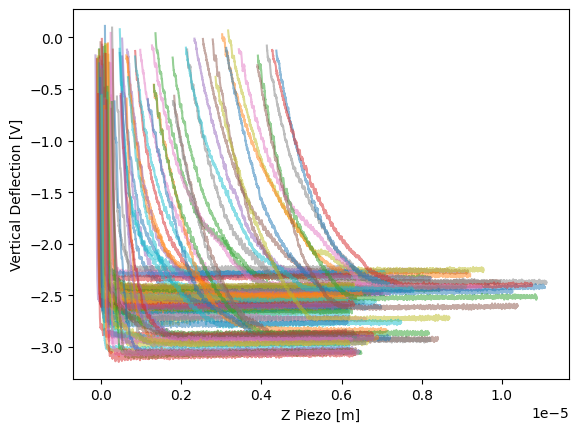

In [4]:
visualize_curves(folder=path, show_every=10)

The `get_rough_topo()` function creates a rough topography using a setpoint in Volts.

To determine this setpoint it can be useful to plot the curves first and visually establish an appropriate value. This is not a final topography, as it is not flattened nor is the substrate set at a 0 height. 

This topography is saved as a .txt file in the "temporary" folder, under the name "rough_topo.txt"

100%|██████████| 1024/1024 [00:30<00:00, 33.62it/s]

31 curves were skipped


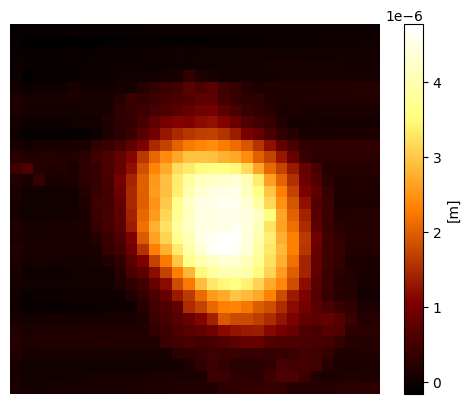

In [4]:
rough_topo=get_rough_topo(folder=path, setpoint=-0.5)


plt.figure()
plt.imshow(rough_topo, cmap='afmhot')
plt.axis('off')
plt.colorbar(label='[m]')
plt.show()

The `sensitivity_analysis()` function calculates the sensitivity in a selected region.

The `use_area_in_rough_topo` parameter, when set to 1, lets you perform the analysis in a selected area of your image. To use this option, you must have calculated a rough topo. Then, run the `get_cutout.py` script. There you can select the area of substrate where you want to calculate the sensitivity. In this case, the folder parameter should be the path of your original curves folder.

If you wish to use an external callibration image set `use_area_in_rough_topo=0`, and set the `folder` parameter to the path of a folder with .txt curves from the desired callibration image. You can use the steps above to also see the callibration curves and topography. Remember to use the format `r'your_path'`

This code calculates the sensitivity's mean and standard deviation and plots the results in a histogram. The mean sensitivity value is saved to perform callibration later in the script. if you wish to enter the sensitivity manually, skip this step.

Sensitivity:3.11e+07 V/m, σ: 2.12e+06 V/m


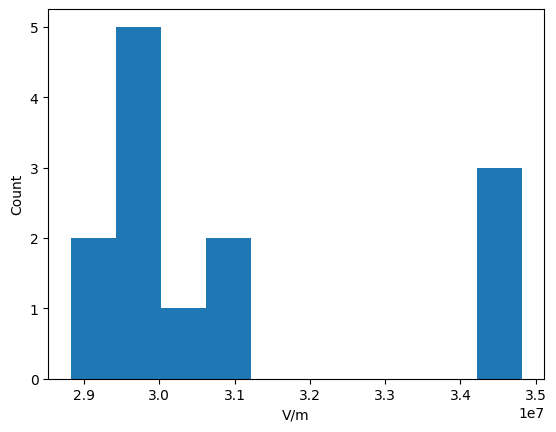

In [5]:
slopes=sensitivity_analysis(folder=path, use_area_in_rough_topo=1)
𝗰𝗹𝗲𝗮𝗿_𝗼𝘂𝘁𝗽𝘂𝘁() 

print(rf'Sensitivity:{np.mean(slopes):.2e} V/m, σ: {np.std(slopes):.2e} V/m')
saved_sensitivity=np.mean(slopes)

plt.figure()
plt.hist(slopes)
plt.xlabel('V/m')
plt.ylabel('Count')
plt.show()


#### Single Curve Porcessing

This section processes a single curve. To select a curve you can either set the `idx` variable to a specefic pixel index in your image or list (more info in the README file).

You can also set the `filename` parameter in the `mechanical_curve()` object as the path of your curve. Note that if you are only using an individual curve, it is not possible to do the analyses from the previous steps and some values, such as the sensitivity and the sample thickness, must be entered manually.

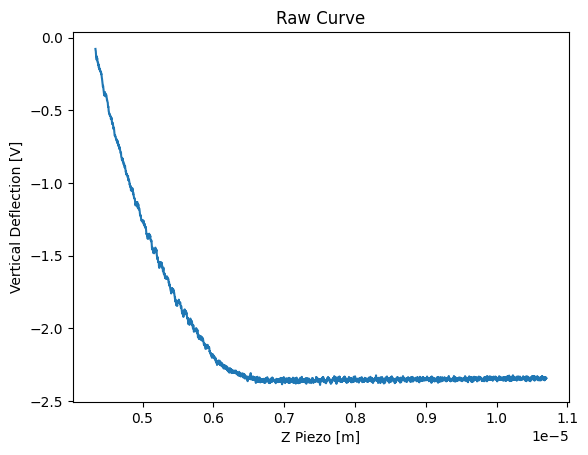

In [6]:
idx=496
file_list = [f for f in listdir(path) if isfile(join(path, f))]
curve_path=rf'{path}\{file_list[idx]}'

# Create a curve object
curve=mechanical_curve(filename=curve_path)

plt.figure()
plt.plot(curve.zpiezo, curve.vdef)
plt.xlabel('Z Piezo [m]')
plt.ylabel('Vertical Deflection [V]')
plt.title('Raw Curve')
plt.show()


#### Curve preprocessing

`correct_baseline()` calculates a linear fit for the baseline and corrects it so that it is set to 0

`zero_x_axis()` calculates and applies a contact point. You can choose 3 different methods for contact point estimation:
* `baseline_stop` uses the estimated end of the baseline calculated using the `correct_baseline()` function
* `idnt_start`uses the estimated start of the indentatation portion calculated using the `fit_idnt()` function
* `div` is a preliminary division between the baseline and the indentation portion of the curve. Mathmatically, it is the maxmimum Fréchet distance after deformation, see the function `deform_curve_from_piecewise_fit()`.

`callibrate()` convers the y-axis from Volts to Newtons. If the sensitivity was calculated using the analysis above, this sensitivity will be saved in the `saved_sensitivity` variable. If enterned manually, the value must be specified in the `sensitivity` parameter.

`correct_bending()` calculates the Tip-Sample distance channel.


In [7]:

# # Correct baseline offset and slope
curve.correct_baseline()


# Apply contact point
curve.zero_x_axis(poc='baseline_stop')


# Callibrate curve
curve.callibrate(sensitivity=saved_sensitivity, k=84.24e-3)

# Calculate tip position
curve.correct_bending()

curve.fit_idnt()

curve.get_height(setpoint=5e-9, use_vdef=0)


c:\Users\mcano\Code2\projects\mechanical_tool\.venv\Lib\site-packages\scipy\stats\_stats_py.py:10729: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
c:\Users\mcano\Code2\projects\mechanical_tool\.venv\Lib\site-packages\scipy\stats\_stats_py.py:10743: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\mcano\Code2\projects\mechanical_tool\.venv\Lib\site-packages\scipy\stats\_stats_py.py:10749: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
c:\Users\mcano\Code2\projects\mechanical_tool\.venv\Lib\site-packages\scipy\stats\_stats_py.py:10729: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
c:\Users\mcano\Code2\projects\mechanical_tool\.venv\Lib\site-packages\scipy\stats\_stats_py.py:10743: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r +

### Curve fitting

This section shows some simple fittings performed on a curve, as well as fittings using double regimes. This section is to be updated to have easy access to all the parameters required by the models. 

The `model` parameter lets you select any of the models in `models.py`

The `inital_guess` parameter  provides the fitting function a start point for each parameter. The order of the values in this vector should correspond with the order in the model's parameter list.

`max_indentation` lets you choose the maximum indentation to take in consieration for the fitting. To use the full curve, set this parameter to `None` or omit it.

`params` lets you fix any parameter in the model. Any parameter that is left unfixed should have a corresponding value in `initial_guess`, otherwise the code will raise an error.

['E', 'Zc'] = [ 4.39758381e+02 -2.16010819e-07]


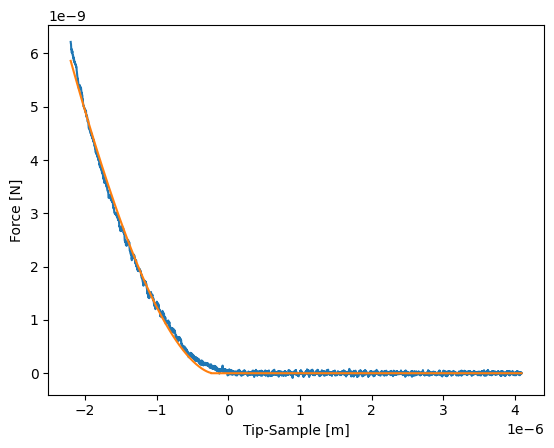

In [9]:
# Perform simple fitting
curve.fit(model=FaSphereGO5good, initial_guess=[1e3,0], max_indentation=None, params = {
    # 'Zc': 0,
    # 'Q': 20,
    'h': curve.topo_height,
    'R': 2.5e-6,
    'dF': 0,
    # 'nu': 0.5
} )

  0%|          | 0/1041 [00:00<?, ?it/s]c:\Users\mcano\Code2\projects\mechanical_tool\preproc.py:523: OptimizeWarning: Covariance of the parameters could not be estimated
  fitted_params, pconv = curve_fit(model_partial, z[0:i], f[0:i], p0=initial_guess)
100%|██████████| 1041/1041 [00:34<00:00, 29.99it/s]


Forward sweep fit: ['E', 'Zc'] = [ 1.63036768e+03 -2.62444184e-07]
Covariances = [1.59212709e+01 3.96510296e-18]


100%|██████████| 1041/1041 [00:30<00:00, 33.94it/s] 


Backward sweep fit: ['E', 'Zc'] = [ 2.80043586e+03 -7.46157362e-07]
Covariances = [1.91602632e+03 1.98280054e-16]


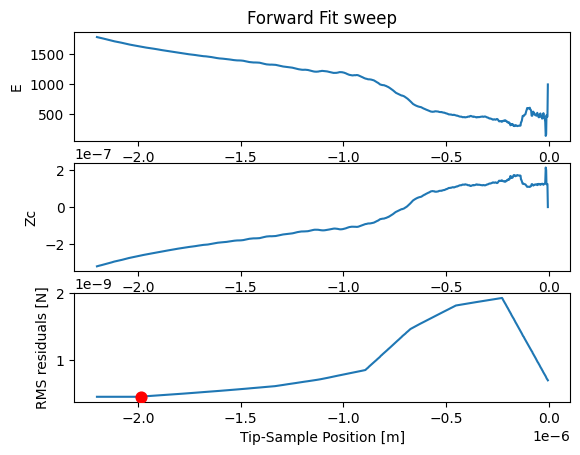

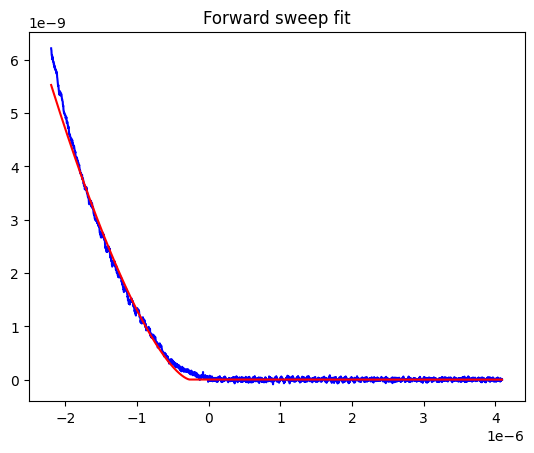

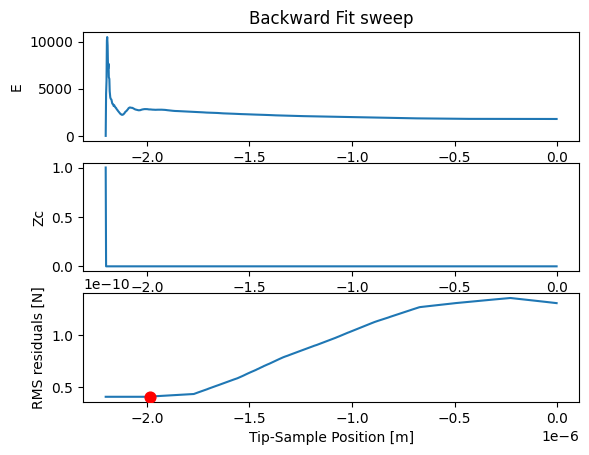

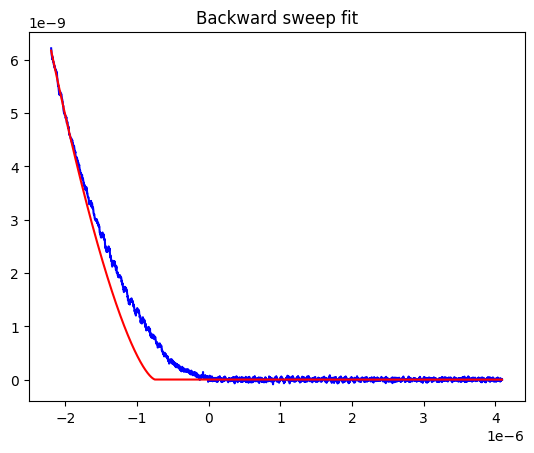

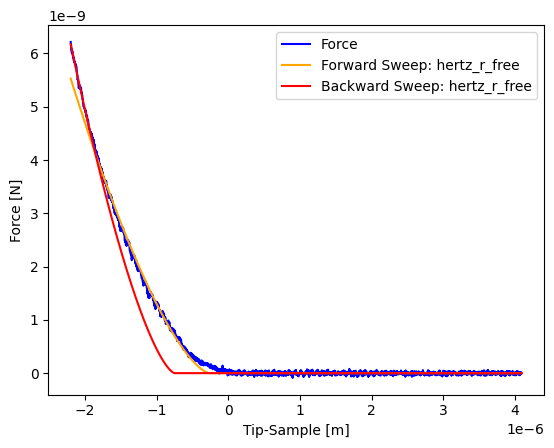

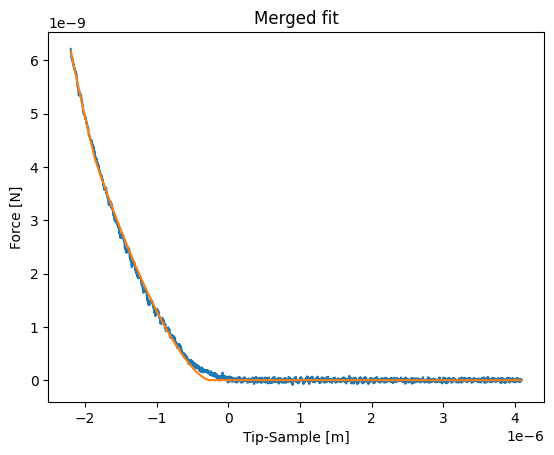

In [8]:
# Perform double-regime fitting

curve.fit_sweep_forward(model=hertz_r_free, initial_guess=[1e3,0], params = {
    # 'Zc': 0,
    # 'Q': 20,
    'R': 0.5e-6,
    # 'h': curve.topo_height,
    'dF': 0,
    'nu': 0.5
} ) 

curve.fit_sweep_backward(model=hertz_r_free, initial_guess=[1e3,0], params = {
    # 'Zc': 0,
    # 'Q': 20,
    'R': 0.5e-6,
    # 'h': curve.topo_height,
    'dF': 0,
    'nu': 0.5
} ) 
curve.merge_fits()


In [ ]:
#save txts
#Loop
